In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import ast
from matplotlib.ticker import FuncFormatter
import json

In [27]:
hatches = {
    "sink-based": "///",  # Triple diagonal lines
    "cluster": "+++",  # Triple plus signs
    "tree": "xxx",  # Triple 'x' marks
    "nova": "ooo",  # Triple circles
    # "chain": "///+++xxx"  # Combination of patterns
}


def format_func(value, tick_number):
    k_value = int(value) // 1000
    if k_value == 0:
        return f"{value:.0f}"
    elif k_value == 1:
        return f"{k_value}k"
    else:
        return f"{k_value:,}k"


def plot_bar_for_type(ax, df, type, val_col, ylabel, plot_order=None, title=True, show_text=True):
    df = df.groupby(['approach', 'type', 'node_id'])[val_col].max().reset_index()
    df = df.groupby(['approach', 'type'])[val_col].mean().reset_index()
    df = df[df['type'] == type]

    if plot_order is None:
        plot_order = df["approach"].tolist()

    for app in plot_order:
        val = df[df['approach'] == app][val_col].tolist()[0]  # Extract the single value
        ax.bar(app, val, color="grey", hatch=hatches[app])
        if show_text:
            ax.text(app, val, f"{val:.0f}", ha='center', va='bottom', fontsize=16)

    if show_text:
        # Calculate the maximum y-axis value
        max_y = ax.get_ylim()[1]
        # Set y-axis limit slightly higher to make space for labels
        ax.set_ylim(0, max_y * 1.4)

    # set title
    if type == "workers":
        type = "workers"
    if title:
        ax.set_title(type)
    ax.set_ylabel(ylabel)

    # Apply the formatting function to the y-axis using FuncFormatter
    formatter = FuncFormatter(format_func)
    ax.yaxis.set_major_formatter(formatter)
    return ax


def convert_bytes_to_megabytes(df, columns):
    for col in columns:
        df[col] = df[col] / (1024 ** 2)  # convert from bytes to megabytes
    return df


def get_type(node_id, sinks, workers, sources):
    type = "invalid"
    node_id = int(node_id)
    if node_id in sinks:
        type = "sinks"
    elif node_id in workers:
        type = "workers"
    elif node_id in sources:
        type = "sources"
    return type


def parse_measurements(root_dir, directory_dict, file_name, type_dict, all_columns, val_columns, skip_head=1):
    rows = []

    for approach, directory in directory_dict.items():
        fname = root_dir + directory + "/" + file_name
        file = open(fname, 'r')
        lines = file.readlines()
        print("Reading lines for", fname)
        sinks, workers, sources = type_dict[approach]
        for line in lines:
            sline = line.split(",", 1)
            timestamp = sline[0]
            dictionary_str = sline[1]
            dictionary = ast.literal_eval(dictionary_str)
            for node_id, metrics_dict in dictionary.items():
                type = get_type(node_id, sinks, workers, sources)
                row = [float(timestamp), node_id, approach, type, float(metrics_dict["cpu_user"]),
                       float(metrics_dict["cpu_nice"]), float(metrics_dict["cpu_system"])]
                rows.append(row)

    df = pd.DataFrame(rows, columns=all_columns)
    df['node_id'] = df['node_id'].astype(int)
    # important pre-processing to remove the min values
    for col in val_columns:
        df[col] = df.groupby(['node_id', 'approach'])[col].transform(lambda x: x - x.min())
    # keep the same amount of measurements
    df['rank'] = df.groupby(['node_id', 'type', 'approach'])['time (s)'].rank().astype(int)
    measurements = df.groupby(['approach'])["rank"].max().min()
    df = df[(df["rank"] > skip_head) & (df["rank"] <= measurements)]
    return df

In [28]:
filename = "cpu_measurements.txt"

directory_dict_join = {
    "sink-based": "sink_based",
    "cluster": "cluster",
    "tree": "tree",
    "nova": "nova"
}

core_cols = ["time (s)", "node_id", "approach", "type"]
columns = {
    "cpu": ["cpu_user", "cpu_nice", "cpu_system"],
    "net": ["R_BYTES", "R_PACKETS", "T_BYTES", "T_PACKETS"]
}

types = ["sinks", "workers", "sources"]
type_list = ([1], [2, 3, 4, 5], [7, 8, 9, 10, 11, 12, 13])

type_dict = {
    "sink-based": type_list,
    "cluster": ([1], [2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12, 13, 14]),
    "tree": type_list,
    "nova": type_list
}

In [29]:
root_dir = "experiments/join_20250301_PI5/"
directory_dict = directory_dict_join

In [30]:
df_cpu_nostress = parse_measurements(root_dir, directory_dict, filename, type_dict, core_cols + columns["cpu"],
                                     columns["cpu"], skip_head=0)
df_cpu_nostress

Reading lines for experiments/join_20250301_PI5/sink_based/cpu_measurements.txt
Reading lines for experiments/join_20250301_PI5/cluster/cpu_measurements.txt
Reading lines for experiments/join_20250301_PI5/tree/cpu_measurements.txt
Reading lines for experiments/join_20250301_PI5/nova/cpu_measurements.txt


,time (s),node_id,approach,type,cpu_user,cpu_nice,cpu_system,rank
0,1.740841e+09,1,sink-based,sinks,0.0,0.0,0.0,1
1,1.740841e+09,2,sink-based,workers,0.0,0.0,0.0,1
2,1.740841e+09,3,sink-based,workers,0.0,0.0,0.0,1
3,1.740841e+09,4,sink-based,workers,0.0,0.0,0.0,1
4,1.740841e+09,5,sink-based,workers,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...
2141,1.740841e+09,9,nova,sources,8107.0,0.0,3163.0,40
2142,1.740841e+09,10,nova,sources,8203.0,0.0,1609.0,40
2143,1.740841e+09,11,nova,sources,8295.0,0.0,1591.0,40
2144,1.740841e+09,12,nova,sources,8289.0,0.0,1634.0,40


## CPU Utilization

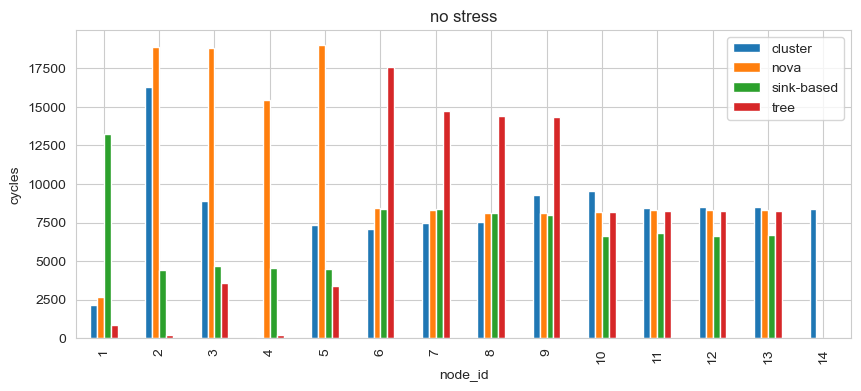

In [31]:
# Create a grouped bar plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 4))
val_col = "cpu_user"

# no stress
grouped_df = df_cpu_nostress.groupby(['node_id', 'approach'])[val_col].max().reset_index()
pivot_df = grouped_df.pivot(index='node_id', columns='approach', values=val_col)
pivot_df.plot(kind='bar', ax=ax1)

# Add labels and title
ax1.set_xlabel('node_id')
ax1.set_ylabel('cycles')
ax1.set_title('no stress')
ax1.legend()

# Show the plot
plt.show()

Creating plot for type sinks
saving plots/cpu/sinks_cpu_user.svg
Creating plot for type workers
saving plots/cpu/workers_cpu_user.svg
Creating plot for type sources
saving plots/cpu/sources_cpu_user.svg


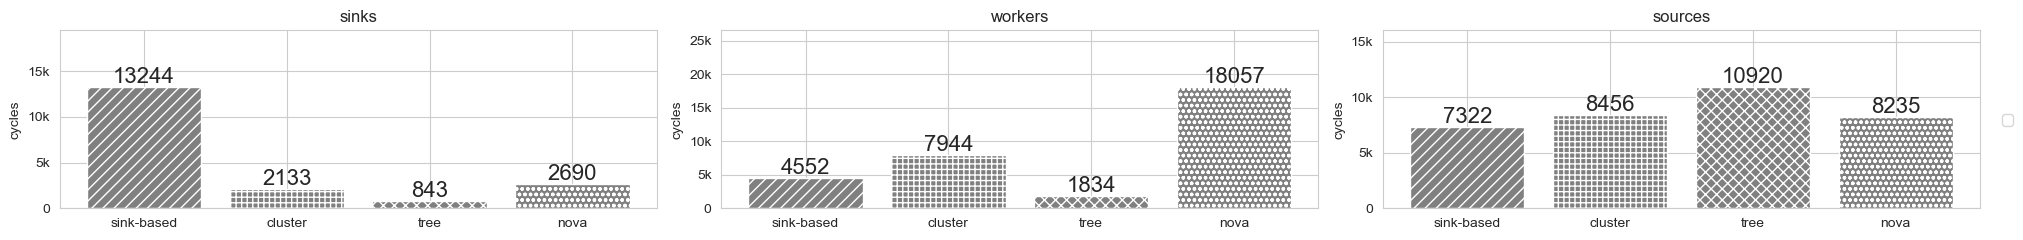

In [32]:
save_dir = "plots/cpu"
plot_col = "cpu_user"
df = df_cpu_nostress

for i, type in enumerate(types):
    # Create a new figure for each subplot
    print("Creating plot for type", type)
    fig, ax1 = plt.subplots(figsize=(8, 2))
    ax1 = plot_bar_for_type(ax1, df, type, plot_col, "cycles", plot_order=directory_dict.keys(), title=False)

    #ax.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.tick_params(axis='x', labelsize=20)

    fig.tight_layout()
    filename = os.path.join(save_dir, f"{type + '_' + plot_col}.svg")
    print("saving", filename)
    fig.savefig(filename)

    # Close the figure to free up memory
    plt.close(fig)

# Create the plot
fig, axs = plt.subplots(nrows=1, ncols=len(types), figsize=(20, 2.5))
for i, type in enumerate(types):
    axs[i] = plot_bar_for_type(axs[i], df, type, "cpu_user", "cycles", plot_order=directory_dict.keys())

# Create the legend outside the loop
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

# Show the plot
plt.show()

## Produced Buffers

In [33]:
buf_dict = {}
for approach, directory in directory_dict.items():
    if approach.endswith("stress"):
        continue

    fname = root_dir + directory + "/number_of_buffers_query_1.txt"
    df = pd.read_csv(fname, names=["timestamp", "buffers"])
    buf_dict[approach] = df

buf_dict.keys()

dict_keys(['sink-based', 'cluster', 'tree', 'nova'])

sink-based 46188
cluster 1501
tree 3888
nova 15128


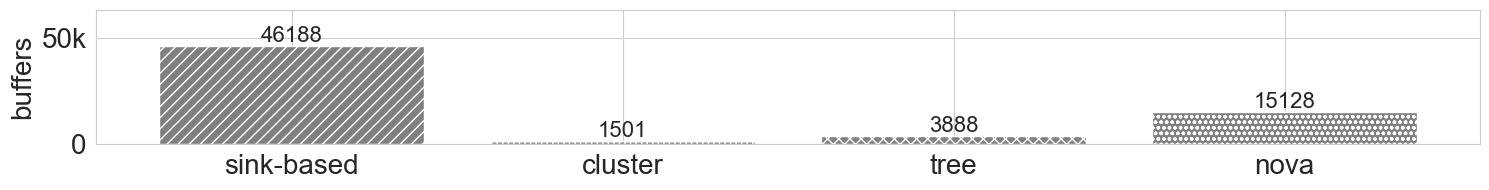

In [34]:
save_dir = "plots/buffers/"

fig, ax1 = plt.subplots(figsize=(15, 2))
key_order = directory_dict.keys()

for k in key_order:
    df = buf_dict[k]
    val = df["buffers"].max()
    if k == "chain":
        val = val / 6
    elif k == "mst":
        val = val / 3

    print(k, val)
    ax1.bar(k, val, hatch=hatches[k], color="grey")
    ax1.text(k, val, f"{val:.0f}", ha='center', va='bottom', fontsize=16)

# Calculate the maximum y-axis value
max_y = ax1.get_ylim()[1]
# Set y-axis limit slightly higher to make space for labels
ax1.set_ylim(0, max_y * 1.3)

plt.ylabel("buffers", fontsize=20)
plt.tick_params(axis='both', labelsize=20)

formatter = FuncFormatter(format_func)
ax1.yaxis.set_major_formatter(formatter)

fig.tight_layout()

plt.savefig(save_dir + "buffers.svg")
plt.show()

## Network

In [35]:
def parse_df(fname, row_number):
    df = pd.read_csv(fname, header=None, names=["timestamp", "json_data"], usecols=[0, 1], delimiter=", {",
                     engine="python")
    df["json_data"] = df['json_data'].apply(lambda x: json.loads("{" + x.replace("'", "\"")))

    # Normalize the JSON data into a flat table
    json_df = pd.json_normalize(df['json_data'])

    # Combine the original timestamp column with the flattened JSON data
    result_df = pd.concat([df['timestamp'], json_df], axis=1)

    flattened = result_df.iloc[row_number]
    # Convert the row to a DataFrame
    row_df = flattened.reset_index()
    row_df.columns = ['column', 'value']

    # Extract prefix (e.g., '1', '2') and sub-column (e.g., 'x', 'y', 'z')
    row_df['node_id'] = row_df['column'].str.split('.').str[0]
    row_df['metric'] = row_df['column'].str.split('.').str[1]

    # Drop the original column name and reorder the DataFrame
    flattened_row_df = row_df.drop(columns=['column'])

    # Pivot the DataFrame to create a separate row for each prefix
    final_row_df = flattened_row_df.pivot_table(index=['node_id', 'metric'], values='value',
                                                aggfunc='first').reset_index()
    final_row_df["approach"] = approach
    return final_row_df

In [36]:
row_number = 30

buf_dict = {}
for approach, directory in directory_dict.items():
    if approach.endswith("stress"):
        continue

    fname = root_dir + directory + "/network_measurements.txt"
    df0 = parse_df(fname, 0)
    df1 = parse_df(fname, row_number)
    df1["value_norm"] = df1["value"] - df0["value"]
    buf_dict[approach] = df1

network_df = pd.concat(buf_dict.values(), ignore_index=True)
network_df

,node_id,metric,value,approach,value_norm
0,1,R_BYTES,4.822757e+10,sink-based,16417880.0
1,1,R_PACKETS,6.053789e+08,sink-based,92833.0
2,1,T_BYTES,5.463667e+10,sink-based,4089701.0
3,1,T_PACKETS,4.191637e+07,sink-based,57197.0
4,10,R_BYTES,7.474913e+10,sink-based,3678203.0
...,...,...,...,...,...
207,8,T_PACKETS,4.230936e+06,nova,122898.0
208,9,R_BYTES,5.525297e+10,nova,13263326.0
209,9,R_PACKETS,6.088743e+08,nova,106852.0
210,9,T_BYTES,3.838185e+10,nova,16362703.0


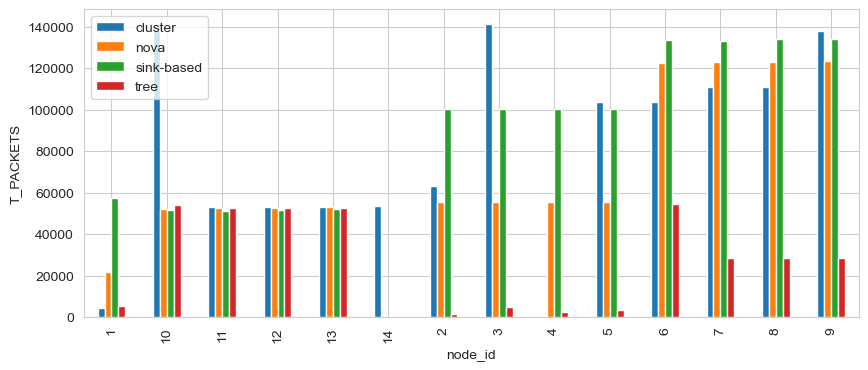

In [37]:
plot_col = "T_PACKETS"

# Create a grouped bar plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 4))
val_col = "value_norm"
fdf = network_df[network_df["metric"] == plot_col][["node_id", "approach", val_col]]

# no stress
grouped_df = fdf.groupby(['node_id', 'approach'])[val_col].max().reset_index()
pivot_df = grouped_df.pivot(index='node_id', columns='approach', values=val_col)
pivot_df.plot(kind='bar', ax=ax1)

# Add labels and title
ax1.set_xlabel('node_id')
ax1.set_ylabel(plot_col)
ax1.legend()

# Show the plot
plt.show()

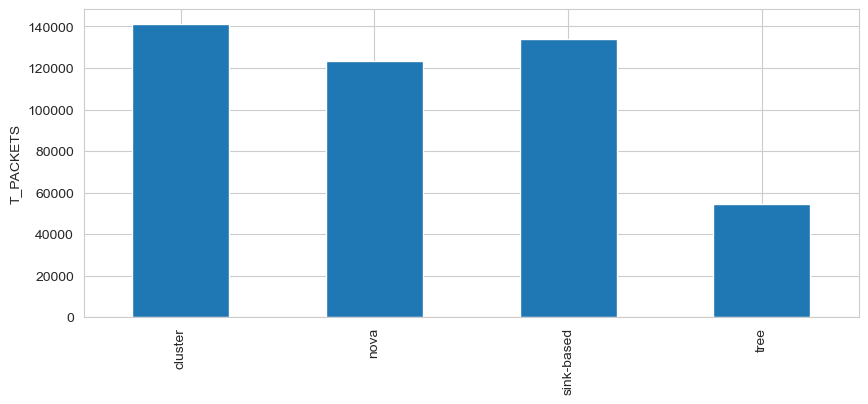

In [49]:
# Create a grouped bar plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 4))
val_col = "value_norm"
fdf = network_df[network_df["metric"] == plot_col][["approach", val_col]]
grouped_df = fdf.groupby(['approach'])[val_col].max()

# no stress
grouped_df.plot(kind='bar', ax=ax1)

# Add labels and title
ax1.set_xlabel('')
ax1.set_ylabel(plot_col)

# Show the plot
plt.show()